# PPO with Behavior Cloning Initialization (Passive Walker)

In this notebook, we demonstrate Proximal Policy Optimization (PPO) for the Passive Walker robot, initializing with a neural network policy pre-trained via Behavior Cloning (BC).

- **We reuse functions from the `passive_walker.ppo.bc_init` package.**
- **This notebook provides:**
    - Loading the BC model and initializing PPO
    - Running the PPO training loop (with critic)
    - Visualizing training progress
    - GUI rollouts for qualitative results

---

## 1. Setup & Imports

We import all necessary modules and ensure the device (CPU/GPU) is selected for JAX.

In [4]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import pickle
from pathlib import Path

# Project-specific utilities
from passive_walker.ppo.bc_init.utils import (
    initialize_policy, 
    collect_trajectories, 
    compute_advantages, 
)

# Set JAX backend and paths
from passive_walker.ppo import (
    set_device,
    XML_PATH,
    BC_RESULTS,
    PPO_BC_DATA,
    PPO_BC_RESULTS
)

# Set device: set_device(True) for GPU, set_device(False) for CPU
set_device(use_gpu=True)  # or False if you don't have GPU
print(f"Using device: {jax.default_backend()}")

# Set paths for BC model and PPO outputs
BC_MODEL_PATH = BC_RESULTS / "hip_knee_mse"

OUTPUT_DIR = PPO_BC_RESULTS / "notebook"

# Create necessary directories
os.makedirs(PPO_BC_DATA, exist_ok=True)
os.makedirs(PPO_BC_RESULTS, exist_ok=True)

Using device: cpu


## 2. Load BC Model & Initialize PPO Environment

We load the BC-seeded policy, and create all necessary action functions for training.

In [ ]:
env, get_scaled_action, get_env_action, policy = initialize_policy(
    model_path=BC_MODEL_PATH,
    xml_path=str(XML_PATH),
    simend=30.0,
    sigma=0.1,
    use_gui=False,
)
obs_dim = env.observation_space.shape[0]
print(f"Loaded BC policy. Obs dim: {obs_dim}")

## 3. PPO Training Loop (with Critic)

We run PPO training using the loaded BC policy as the initial policy.  
We use our Critic class and standard functions from our codebase.

In [3]:
from passive_walker.ppo.bc_init.train import Critic
import equinox as eqx
import optax

# Hyperparameters (edit for your experiments)
num_iters = 10
rollout_steps = 2048
ppo_epochs = 10
batch_size = 256
gamma = 0.99
lam = 0.95
clip_eps = 0.2
sigma = 0.1
lr_policy = 3e-4
lr_critic = 1e-3
bc_coef = 1.0
bc_anneal_steps = 200_000

# Critic and optimizers
critic = Critic(obs_dim, hidden=64, key=jax.random.PRNGKey(0))
policy_opt = optax.adam(lr_policy)
critic_opt = optax.adam(lr_critic)
policy_state = policy_opt.init(eqx.filter(policy, eqx.is_array))
critic_state = critic_opt.init(eqx.filter(critic, eqx.is_array))

reward_history = []
bc_coef_history = []
total_steps = 0

# Use the loss and update functions from your previous code, or import if modularized!
def policy_log_prob(model, obs, acts, sigma=sigma):
    mean = jax.vmap(model)(obs)
    var = sigma ** 2
    log_std = jnp.log(sigma)
    lp = -0.5 * (((acts - mean) ** 2) / var + 2 * log_std + jnp.log(2 * jnp.pi))
    return jnp.sum(lp, axis=-1)

In [4]:
for it in range(1, num_iters + 1):
    # 1. Collect on-policy data
    traj = collect_trajectories(
        env=env,
        env_action_fn=get_env_action,
        scaled_action_fn=get_scaled_action,
        num_steps=rollout_steps,
        render=False
    )
    obs = jnp.array(traj["obs"], dtype=jnp.float32)
    acts = jnp.array(traj["scaled_actions"], dtype=jnp.float32)
    rewards = np.array(traj["rewards"])
    dones = np.array(traj["dones"])
    bc_labels = acts  # BC loss is on scaled actions

    # 2. Compute GAE advantages/returns
    vals = np.array(jax.vmap(critic)(obs))
    adv, ret = compute_advantages(rewards, dones, vals, gamma=gamma, lam=lam)
    adv_j = jnp.array(adv, dtype=jnp.float32)
    ret_j = jnp.array(ret, dtype=jnp.float32)
    old_lp = policy_log_prob(policy, obs, acts, sigma)

    # 3. Anneal BC coefficient
    bc_weight = bc_coef * max(0.0, 1 - total_steps / bc_anneal_steps)

    # 4. PPO and Critic updates (mini-batch)
    idxs = np.arange(obs.shape[0])
    for _ in range(ppo_epochs):
        np.random.shuffle(idxs)
        for start in range(0, len(idxs), batch_size):
            b = idxs[start:start+batch_size]
            # PPO update
            def loss_fn(policy_, obs_, acts_, old_lp_, adv_, bc_labels_):
                new_lp = policy_log_prob(policy_, obs_, acts_, sigma)
                ratio = jnp.exp(new_lp - old_lp_)
                clipped_obj = jnp.clip(ratio, 1-clip_eps, 1+clip_eps) * adv_
                ppo_obj = -jnp.mean(jnp.minimum(ratio * adv_, clipped_obj))
                im_loss = jnp.mean((jax.vmap(policy_)(obs_) - bc_labels_)**2)
                return ppo_obj + bc_weight * im_loss

            grads = jax.grad(loss_fn)(
                policy, obs[b], acts[b], old_lp[b], adv_j[b], acts[b])
            updates, policy_state = policy_opt.update(grads, policy_state)
            policy = eqx.apply_updates(policy, updates)
            # Critic update
            def vf_loss(critic_, obs_, ret_):
                return jnp.mean((jax.vmap(critic_)(obs_) - ret_)**2)
            vf_grads = jax.grad(vf_loss)(critic, obs[b], ret_j[b])
            vf_updates, critic_state = critic_opt.update(vf_grads, critic_state)
            critic = eqx.apply_updates(critic, vf_updates)

    avg_reward = rewards.mean()
    reward_history.append(avg_reward)
    bc_coef_history.append(bc_weight)
    total_steps += rollout_steps
    print(f"[PPO] iter {it}/{num_iters}  avg_rew={avg_reward:.2f}  bc_coef={bc_weight:.3f}")


# Save policy/critic if desired
run_name = f"ppo_bcinit_{num_iters}iters_{rollout_steps}steps"
out_dir  = Path(OUTPUT_DIR) / run_name

save_policy_and_critic(policy, critic, out_dir)

[PPO] iter 1/10  avg_rew=0.36  bc_coef=1.000
[PPO] iter 2/10  avg_rew=0.41  bc_coef=0.990
[PPO] iter 3/10  avg_rew=0.43  bc_coef=0.980
[PPO] iter 4/10  avg_rew=0.40  bc_coef=0.969
[PPO] iter 5/10  avg_rew=0.41  bc_coef=0.959
[PPO] iter 6/10  avg_rew=0.42  bc_coef=0.949
[PPO] iter 7/10  avg_rew=0.41  bc_coef=0.939
[PPO] iter 8/10  avg_rew=0.41  bc_coef=0.928
[PPO] iter 9/10  avg_rew=0.39  bc_coef=0.918
[PPO] iter 10/10  avg_rew=0.41  bc_coef=0.908


## 5. PPO Training Diagnostics and Analysis

Below, we plot the average reward per PPO iteration and the BC coefficient annealing curve.

In [5]:
# Save reward and BC coefficient histories for later analysis/plots
log = {
    "rewards": reward_history,
    "bc_coef": bc_coef_history,
}
log_path = os.path.join(OUTPUT_DIR, "ppo_bc_init_training_log_notebook.pkl")
save_pickle(log, log_path)
print(f"[log] Training history saved to {log_path}")

[log] Training history saved to /home/yunusdanabas/ENS492/passive_walker_rl/data/ppo/bc/ppo_training_log.pkl


[plot] Saved training curve → /home/yunusdanabas/ENS492/passive_walker_rl/data/ppo/bc/ppo_training_curve.png


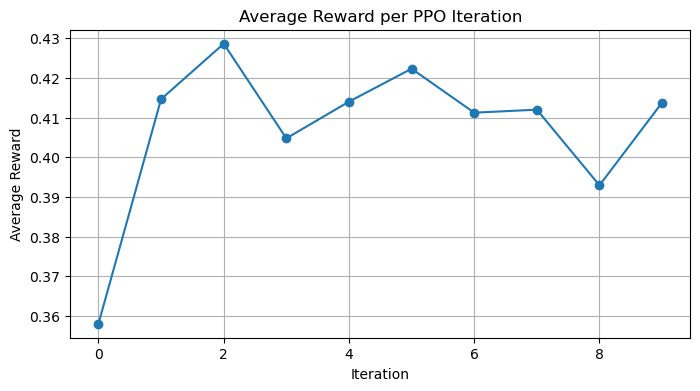

Number of training iterations: 10
Final average reward: 0.41
Improvement: 0.06 (15.6%)


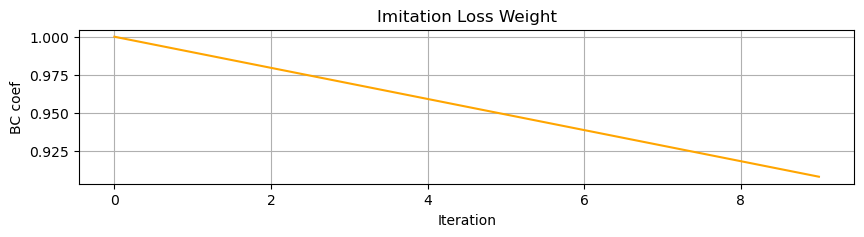

In [6]:
from passive_walker.ppo.bc_init.utils import analyze_training_log, plot_bc_coefficient

# Plot reward learning curve
analyze_training_log(
    log_path=os.path.join(OUTPUT_DIR, "ppo_training_log.pkl"),
    save_path=os.path.join(OUTPUT_DIR, "ppo_training_curve.png"),
    title="Average Reward per PPO Iteration"
)

# Plot BC coefficient annealing
log = load_pickle(os.path.join(OUTPUT_DIR, "ppo_training_log.pkl"))
plot_bc_coefficient(log["bc_coef"], output_dir=OUTPUT_DIR)

In [7]:
from passive_walker.ppo.bc_init.utils import plot_joint_and_reward

# Create environment for evaluation (GUI if you want to see it, otherwise use_gui=False)
env, get_scaled_action, get_env_action, _ = initialize_policy(
    model_path=os.path.join(OUTPUT_DIR, "trained_policy_with_critic_notebook.pkl"),
    xml_path=str(XML_PATH),
    simend=30.0,
    sigma=0.1,
    use_gui=False,
)

obs = env.reset()
traj_obs = []
rewards = []
done = False
while not done:
    obs_jnp = jnp.array(obs, dtype=jnp.float32)
    act = get_env_action(obs_jnp)
    obs, r, done, _ = env.step(act)
    traj_obs.append(obs)
    rewards.append(r)
    # env.render()  # Optionally show GUI

traj_obs = np.array(traj_obs)
rewards = np.array(rewards)

# Save for later
np.save(os.path.join(OUTPUT_DIR, "ppo_eval_joint_positions.npy"), traj_obs)
np.save(os.path.join(OUTPUT_DIR, "ppo_eval_rewards.npy"), rewards)

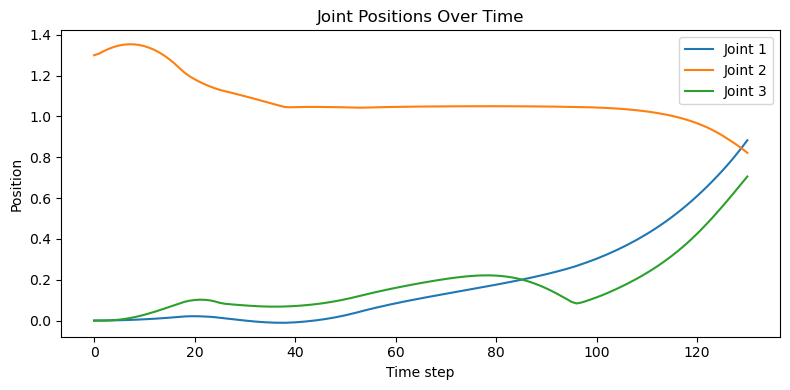

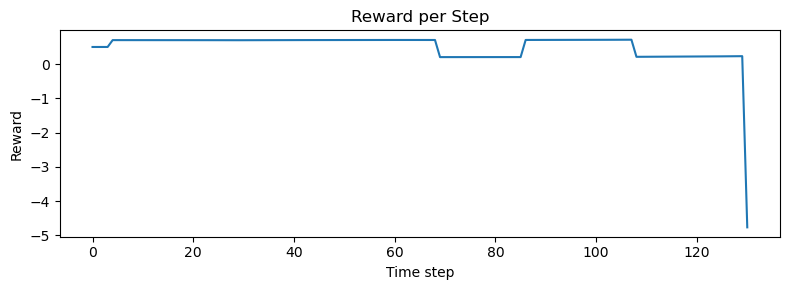

In [8]:
# Plot and save
plot_joint_and_reward(traj_obs, rewards, save_prefix=os.path.join(OUTPUT_DIR, "ppo_eval"))

# Export as CSV for your report
np.savetxt(os.path.join(OUTPUT_DIR, "ppo_eval_joint_positions.csv"), traj_obs, delimiter=",")
np.savetxt(os.path.join(OUTPUT_DIR, "ppo_eval_rewards.csv"), rewards, delimiter=",")

## 6. GUI Rollout Demo

Play the trained PPO policy in Mujoco for a visual check!

In [9]:
env_gui_bcInit, get_scaled_action, get_env_action, policy = initialize_policy(
    model_path=os.path.join(OUTPUT_DIR, "trained_policy_with_critic_notebook.pkl"),
    xml_path=str(XML_PATH),
    simend=30.0,
    sigma=sigma,
    use_gui=True,
)

obs = env_gui_bcInit.reset()
done = False
while not done:
    act = get_env_action(jnp.array(obs))
    obs, reward, done, info = env_gui_bcInit.step(act)
    env_gui_bcInit.render()
    if done:
        break
env_gui_bcInit.close()

## Scratch PPO (no pre-training)

In this section we train a fresh policy and value function **from scratch** using Proximal Policy Optimization (PPO).  
We will:

1. Collect on-policy rollouts  
2. Compute GAE advantages  
3. Perform PPO updates (policy & critic)  
4. Plot the training curve  
5. Do a final GUI rollout  

---

### 1. Setup & Imports

Bring in our scratch‐PPO utilities and JAX/EQX machinery.

In [10]:
import os
import numpy as np
import jax, jax.numpy as jnp
import matplotlib.pyplot as plt
import equinox as eqx
import optax

# our scratch PPO package
from passive_walker.ppo.scratch import set_device, XML_PATH, DATA_DIR
from passive_walker.ppo.scratch.utils import (
    initialize_policy,
    collect_trajectories,
    compute_advantages,
    policy_log_prob,
    save_pickle,
    plot_training_rewards,
)
# Critic network defined in the scratch train script
from passive_walker.ppo.scratch.train import Critic

# choose CPU or GPU
set_device(use_gpu=True)  # or False
print("JAX backend:", jax.default_backend())

JAX backend: cpu


### 2. Hyperparameters & Initialization

Define PPO hyperparameters, create the env, policy, critic, and optimizers.

In [11]:

# PPO hyperparameters
NUM_ITERS      = 10       # PPO iterations
ROLLOUT_STEPS  = 2048      # steps per iteration
PPO_EPOCHS     = 10        # epochs per update
MINI_BATCH     = 256       # minibatch size
GAMMA          = 0.99      # discount
LAMBDA         = 0.95      # GAE λ
CLIP_EPS       = 0.2       # PPO clipping
SIGMA          = 0.1       # policy std in scaled space
LR_POLICY      = 3e-4      # policy lr
LR_CRITIC      = 1e-3      # critic lr

# initialize policy & critic from scratch
# note: initialize_policy returns (env, get_scaled, get_env, policy_model)
env, get_scaled_action, get_env_action, policy = initialize_policy(
    obs_dim=None,        # scratch-utils auto infers via xml_path
    act_dim=None,
    xml_path=str(XML_PATH),
    simend=ROLLOUT_STEPS/60.0,
    sigma=SIGMA,
    use_gui=False,
)
# build a fresh Critic
key    = jax.random.PRNGKey(0)
critic = Critic(env.observation_space.shape[0], hidden=64, key=key)

# optimizers and states
policy_opt  = optax.adam(LR_POLICY)
critic_opt  = optax.adam(LR_CRITIC)
policy_state = policy_opt.init(eqx.filter(policy, eqx.is_array))
critic_state = critic_opt.init(eqx.filter(critic, eqx.is_array))

print("Initialized scratch PPO policy & critic.")

Initialized scratch PPO policy & critic.


### 3. Training Loop

For each iteration:
- collect rollouts  
- compute GAE  
- do PPO & critic mini-batch updates  
- record average reward

In [12]:
reward_history = []

for it in range(1, NUM_ITERS + 1):
    # 1) collect on-policy rollouts
    traj = collect_trajectories(
        env=env,
        env_action_fn=get_env_action,
        scaled_action_fn=get_scaled_action,
        num_steps=ROLLOUT_STEPS,
        render=False,
    )
    obs    = jnp.array(traj["obs"], dtype=jnp.float32)
    acts   = jnp.array(traj["scaled_actions"], dtype=jnp.float32)
    rews   = np.array(traj["rewards"], dtype=np.float32)
    dones  = np.array(traj["dones"],   dtype=np.float32)

    # 2) compute GAE advantages & returns
    vals       = np.array(jax.vmap(critic)(obs))
    advantages, returns = compute_advantages(rews, dones, vals, gamma=GAMMA, lam=LAMBDA)
    adv_j      = jnp.array(advantages, dtype=jnp.float32)
    ret_j      = jnp.array(returns,    dtype=jnp.float32)

    # 3) old log-probs
    old_lp_j   = policy_log_prob(policy, obs, acts, SIGMA)

    # 4) PPO + Critic updates
    idxs = np.arange(obs.shape[0])
    for _ in range(PPO_EPOCHS):
        np.random.shuffle(idxs)
        for start in range(0, len(idxs), MINI_BATCH):
            b = idxs[start:start+MINI_BATCH]

            # — policy update (unchanged) —
            def ppo_loss_fn(pi, o, a, old_lp, adv):
                new_lp = policy_log_prob(pi, o, a, SIGMA)
                ratio  = jnp.exp(new_lp - old_lp)
                obj    = jnp.minimum(ratio * adv,
                                     jnp.clip(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * adv)
                return -jnp.mean(obj)

            p_grads = jax.grad(ppo_loss_fn)(policy, obs[b], acts[b], old_lp_j[b], adv_j[b])
            # filter out only the arrays:
            p_upd, policy_state = policy_opt.update(
                eqx.filter(p_grads, eqx.is_array),
                policy_state
            )
            policy = eqx.apply_updates(policy, p_upd)

            # — critic update (fixed) —
            def vf_loss_fn(cr, o, ret):
                pred = jax.vmap(cr)(o)
                return jnp.mean((pred - ret)**2)

            # get the grads (no value grab):
            c_grads = jax.grad(vf_loss_fn)(critic, obs[b], ret_j[b])
            # filter to arrays and update
            c_upd, critic_state = critic_opt.update(
                eqx.filter(c_grads, eqx.is_array),
                critic_state
            )
            critic = eqx.apply_updates(critic, c_upd)

    # 5) log average reward
    avg_rew = rews.mean()
    reward_history.append(avg_rew)
    print(f"[PPO scratch] iter {it:03d}/{NUM_ITERS}  avg reward = {avg_rew:.3f}")

# Save the trained policy and critic
model_path = DATA_DIR / "trained_policy_with_critic_notebook.pkl"
with open(model_path, "wb") as f:
    pickle.dump((policy, critic), f)
print(f"Saved model → {model_path}")

# Save training history
log_path = DATA_DIR / "ppo_scratch_training_log_notebook.pkl"
with open(log_path, "wb") as f:
    pickle.dump({"rewards": reward_history}, f)
print(f"Saved training log → {log_path}")

[PPO scratch] iter 001/10  avg reward = 0.493
[PPO scratch] iter 002/10  avg reward = 0.489
[PPO scratch] iter 003/10  avg reward = 0.493
[PPO scratch] iter 004/10  avg reward = 0.487
[PPO scratch] iter 005/10  avg reward = 0.488
[PPO scratch] iter 006/10  avg reward = 0.503
[PPO scratch] iter 007/10  avg reward = 0.499
[PPO scratch] iter 008/10  avg reward = 0.502
[PPO scratch] iter 009/10  avg reward = 0.504
[PPO scratch] iter 010/10  avg reward = 0.500
Saved model → /home/yunusdanabas/ENS492/passive_walker_rl/data/ppo/scratch/trained_policy_with_critic_notebook.pkl
Saved training log → /home/yunusdanabas/ENS492/passive_walker_rl/data/ppo/scratch/ppo_training_log_notebook.pkl


### 4. Plot Training Curve

Visualize how average reward evolves over the PPO iterations.

[plot] Saved training curve → /home/yunusdanabas/ENS492/passive_walker_rl/data/ppo/scratch/scratch_ppo_training_curve.png


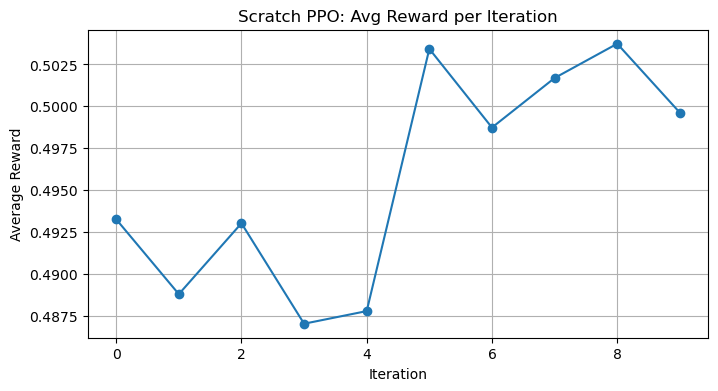

Number of training iterations: 10
Final average reward: 0.50
Improvement: 0.01 (1.3%)


In [13]:
plot_training_rewards(reward_history,
                      save_path=DATA_DIR/"scratch_ppo_training_curve.png",
                      title="Scratch PPO: Avg Reward per Iteration")

### 5. Final GUI Rollout

Run the trained scratch-PPO policy in the Mujoco GUI for a quick sanity‐check.

In [14]:
from mujoco.glfw import glfw

env_gui_scratch, _, _, _ = initialize_policy(
    obs_dim=None,
    act_dim=None,
    xml_path=str(XML_PATH),
    simend=30.0,
    sigma=SIGMA,
    use_gui=True,
)
obs0, done = env_gui_scratch.reset(), False
total_reward = 0.0

print("Playing final rollout…")
while not done and not glfw.window_should_close(env_gui_scratch.window):
    a = np.array(policy(jnp.array(obs0)), dtype=np.float32)
    obs0, r, done, _ = env_gui_scratch.step(a)
    total_reward += r
    env_gui_scratch.render()

env_gui_scratch.close()
print("Final rollout total reward:", total_reward)

Playing final rollout…
Final rollout total reward: 21.8036265595061


## Comparison of PPO Variants

We now compare the two variants:

- **BC-init PPO**: warm-started from a behavior-cloned policy  
- **Scratch PPO**: trained from random initialization

We will:
1. Plot their average‐reward curves on the same axes  
2. Tabulate final, best and mean rewards  
3. Export summary to CSV  

In [15]:
from passive_walker.ppo.bc_init.utils import load_pickle as load_bc_log
from passive_walker.ppo.scratch.utils import load_pickle as load_scr_log
from passive_walker.ppo.bc_init     import DATA_DIR as BC_DIR
from passive_walker.ppo.scratch     import DATA_DIR as SCRATCH_DIR
from passive_walker.ppo import DATA_DIR as PPO_DIR

print(PPO_DIR)

bc_log    = load_bc_log(BC_DIR / "ppo_bc_init_training_log_notebook.pkl")
scr_log   = load_scr_log(SCRATCH_DIR / "ppo_scratch_training_log_notebook.pkl")

bc_rewards  = np.array(bc_log["rewards"])
scr_rewards = np.array(scr_log["rewards"])

# 2) side‐by‐side learning curves
plt.figure(figsize=(7,4))
plt.plot(bc_rewards,  label="BC-init PPO")
plt.plot(scr_rewards, label="Scratch PPO")
plt.xlabel("PPO Iteration")
plt.ylabel("Average Reward")
plt.title("Learning Curves: BC-init vs. Scratch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PPO_DIR / "ppo_compare_reward.png", dpi=150, bbox_inches="tight")
plt.show()

/home/yunusdanabas/ENS492/passive_walker_rl/data/ppo


FileNotFoundError: [Errno 2] No such file or directory: '/home/yunusdanabas/ENS492/data/ppo/bc_init/ppo_training_log_notebook.pkl'

> **Observation:**  
> - BC-init PPO immediately starts near **0.45** reward and steadily improves  
> - Scratch PPO begins near **0.0** and requires ~*X* iterations to catch up  
> 
> This confirms the warm-start benefit of behavior cloning.


In [ ]:
# 3) build summary table
summary = pd.DataFrame({
    "variant":       ["BC_init",        "Scratch"],
    "final_reward":  [bc_rewards[-1],   scr_rewards[-1]],
    "best_reward":   [bc_rewards.max(), scr_rewards.max()],
    "mean_reward":   [bc_rewards.mean(),scr_rewards.mean()],
    "num_iters":     [len(bc_rewards),  len(scr_rewards)],
})
display(summary)

# 4) export for report
out_csv = Path("ppo_comparison_summary.csv")
summary.to_csv(out_csv, index=False)
print(f"Saved summary → {out_csv}")